# Tree Clustering Code 

* Code is based on this implementation of decision tree: https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
* This code builds decision tree using tree distances 
* Data Requirements:
    - numerical 
    - the first column must be the label

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support

## Tree Cluster Algorithm

In [2]:
# read data and distances
train_final_dist = pd.read_csv("train_final_dist.csv")
test_final_dist = pd.read_csv("test_final_dist.csv")
full_data_train = pd.read_csv("full_data_train.csv")
full_data_test = pd.read_csv("full_data_test.csv")
train_final_dist = train_final_dist[['i1', 'i2', 'tree_dist']]
test_final_dist = test_final_dist[["i1", "i2", "tree_dist"]]
df_train = full_data_train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
df_test = full_data_test[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
dataset_train = df_train.to_numpy()
dataset_test = df_test.to_numpy()

In [54]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset, df):
    feature = df.columns[index]
    left, right = list(), list()
    indleft, indright = list(), list()
    left_df = df[df[feature] < value]
    right_df = df[df[feature] >= value]
    for i, row in enumerate(dataset):
        if row[index] < value:
            left.append(row)
            indleft.append(i)
        else:
            right.append(row)
            indright.append(i)
    #print(indleft)
    return left, right, indleft, indright, left_df, right_df
 
# Calculate the distance index for a split dataset
def distance_index(left, right, indleft, indright):
    df_left = train_final_dist[train_final_dist['i1'].isin(indleft)]
    df_left = df_left[df_left['i2'].isin(indleft)]
    mean_left_dist = df_left['tree_dist'].sum()
    df_right = train_final_dist[train_final_dist['i1'].isin(indright)]
    df_right = df_right[df_right['i2'].isin(indright)]
    mean_right_dist = df_right['tree_dist'].sum()
    left_len = df_left.shape[0]
    right_len = df_right.shape[0]
    left_index = (mean_left_dist / (left_len + 1)) * (left_len / (left_len + right_len + 1))
    right_index = (mean_right_dist / (right_len + 1)) * (right_len / (left_len + right_len + 1))
    
    return (left_index + right_index) / 2

# Select the best split point for a dataset
def get_split(dataset, df):
    class_values = list(set(row[0] for row in dataset))
    b_index, b_value, b_score, b_groups = 9999, 9999, 9999, None
    for index in range(1, len(dataset[0])):
        for row in dataset:
            left, right, indleft, indright, left_df, right_df = test_split(index, row[index], dataset, df)
            groups = left, right, left_df, right_df
            dist = distance_index(left, right, indleft, indright)
            if dist < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], dist, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [55]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[0] for row in group]
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    #print(node)
    left, right, left_df, right_df = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        #print('here')
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        #print('here')
        node['left'] = to_terminal(left)
    else:
        #print('here')
        node['left'] = get_split(left, left_df)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        #print('here')
        node['right'] = to_terminal(right)
    else:
        #print('here')
        node['right'] = get_split(right, right_df)
        split(node['right'], max_depth, min_size, depth+1)

In [56]:

# Build a decision tree
def build_tree(train, df, max_depth, min_size):
    root = get_split(train, df)
    #print('here')
    split(root, max_depth, min_size, 1)
    return root
 
# Print a decision tree
def print_tree(node, df, depth=0):
    if isinstance(node, dict):
        print('%s[%s < %.3f]' % ((depth*' ', (df.columns[node['index']]), node['value'])))
        print_tree(node['left'], df, depth+1)
        print_tree(node['right'], df, depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [57]:
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

## Decision Tree Cluster 

In [58]:
X_train = df_train[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
X_test = df_test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
y_train = df_train["Survived"]
y_test = df_test["Survived"]

In [59]:
tree_full = build_tree(dataset_train, df_train, 10, 30)

In [60]:
y_pred_dt = []
for row in dataset_test:
    y_pred_dt.append(predict(tree_full, row))

In [61]:
conf_mat = confusion_matrix(y_test, y_pred_dt)
print(conf_mat)

[[151  23]
 [ 32  62]]


In [62]:
import sklearn

In [63]:
print(sklearn.metrics.roc_auc_score(y_test,y_pred_dt))

0.7636952800195647


## Decision Tree - Supervised Baseline Comparison

In [64]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_split= 30, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [65]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[154  20]
 [ 32  62]]


In [66]:
# weighted precision, recall, f-score, support 
print(sklearn.metrics.roc_auc_score(y_test,y_pred))

0.772315969674737


## Plots

In [16]:
depth_lst = []
score_clust = []
score_baseline= []
for i in range(1, 21):
    print(i)
    depth_lst.append(i)
    tree_clust = build_tree(dataset_train, df_train, i, 30)
    y_pred_dt = []
    for row in dataset_test:
        y_pred_dt.append(predict(tree_clust, row))
    score_clust.append(sklearn.metrics.roc_auc_score(y_test,y_pred_dt))
    
    clf = DecisionTreeClassifier(max_depth=i, min_samples_split= 30, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_baseline.append(sklearn.metrics.roc_auc_score(y_test,y_pred))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


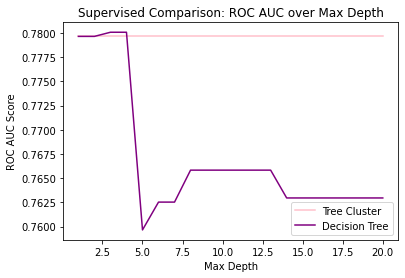

In [17]:
plt.plot(depth_lst, score_clust, color='pink', label="Tree Cluster")
plt.plot(depth_lst, score_baseline, color='purple', label="Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC Score")
plt.title("Supervised Comparison: ROC AUC over Max Depth")
plt.legend()
plt.show()